# Team 2: Differential Vorticity Advection Term

## Matt S, Andrew R, Kennedy S

## 1) Imports

In [1]:
import sys
sys.path.append('/home/decker/lab433')

from datetime import datetime

from synoptic import MODEL

from metpy.units import units
from metpy.constants import dry_air_gas_constant as R
from metpy.io import GempakGrid
import metpy.calc as mpcalc
from metpy.plots import FilledContourPlot, MapPanel, PanelContainer

## 2) Get the data

In [2]:
gem_file_name = MODEL + 'nam/24101612_nam211.gem'
gem_file = GempakGrid(gem_file_name)

In [3]:
p1 = 500
p2 = 900
f0 = 1.028e-4

plot_time = datetime(2024, 10, 16, 18)

htp1 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p1)[0]
up1 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=p1)[0]
vp1 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=p1)[0]

htp2 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p2)[0]
up2 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=p2)[0]
vp2 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=p2)[0]

htp1 = htp1 * units('m')
up1 = up1 * units('m/s')
vp1 = vp1 * units('m/s')

htp2 = htp2 * units('m')
up2 = up2 * units('m/s')
vp2 = vp2 * units('m/s')

smoothing = 16
htp1 = mpcalc.smooth_gaussian(htp1, smoothing)
htp2 = mpcalc.smooth_gaussian(htp2, smoothing)
up1 = mpcalc.smooth_gaussian(up1, smoothing)
vp1 = mpcalc.smooth_gaussian(vp1, smoothing)
up2 = mpcalc.smooth_gaussian(up2, smoothing)
vp2 = mpcalc.smooth_gaussian(vp2, smoothing)


## 3) Calculate

In [4]:
up1_geo, vp1_geo = mpcalc.geostrophic_wind(htp1)
up2_geo, vp2_geo = mpcalc.geostrophic_wind(htp2)

absvor_p1 = mpcalc.absolute_vorticity(up1_geo, vp1_geo)
absvor_p2 = mpcalc.absolute_vorticity(up2_geo, vp2_geo)

advp1 = mpcalc.advection(absvor_p1, up1_geo, vp1_geo)
advp2 = mpcalc.advection(absvor_p2, up2_geo, vp2_geo)

term1 = f0 / ((p2-p1))

term2 = advp1.squeeze('pres') - advp2.squeeze('pres')

finalterm = term1 * term2

finalterm

Magnitude,[[[3.287877197840663e-18 5.2027683714745895e-18 4.793096960008644e-18 ... 2.7599932384701698e-18 3.357135480802764e-18 -6.738019490329169e-19] [-1.1119207986562255e-18 -1.347828022990182e-18 -4.621496146535133e-18 ... -1.0047519465255734e-17 -6.995404619356192e-18 -7.515700169975911e-18] [-1.0316253792533645e-17 -1.4717740623648418e-17 -2.261222835583122e-17 ... -3.882687830977665e-18 -1.7777518969014836e-18 -3.6721157020081095e-18] ... [5.266742759308148e-18 8.316684263908071e-18 -3.580423578453046e-17 ... 1.6763342977322904e-16 1.5385875474690436e-16 4.298581703541513e-17] [6.8015459563090815e-18 9.743929710375541e-18 -1.6034463193058743e-17 ... 9.595591316569131e-17 8.941205849538629e-17 2.3126549877306776e-17] [1.7772598031232166e-18 -1.808500933686686e-19 -1.3508323424593189e-17 ... 4.002652488923699e-17 3.8770643136128375e-17 1.0730247394795372e-17]]]
Units,1/second2


## 4) Plot it

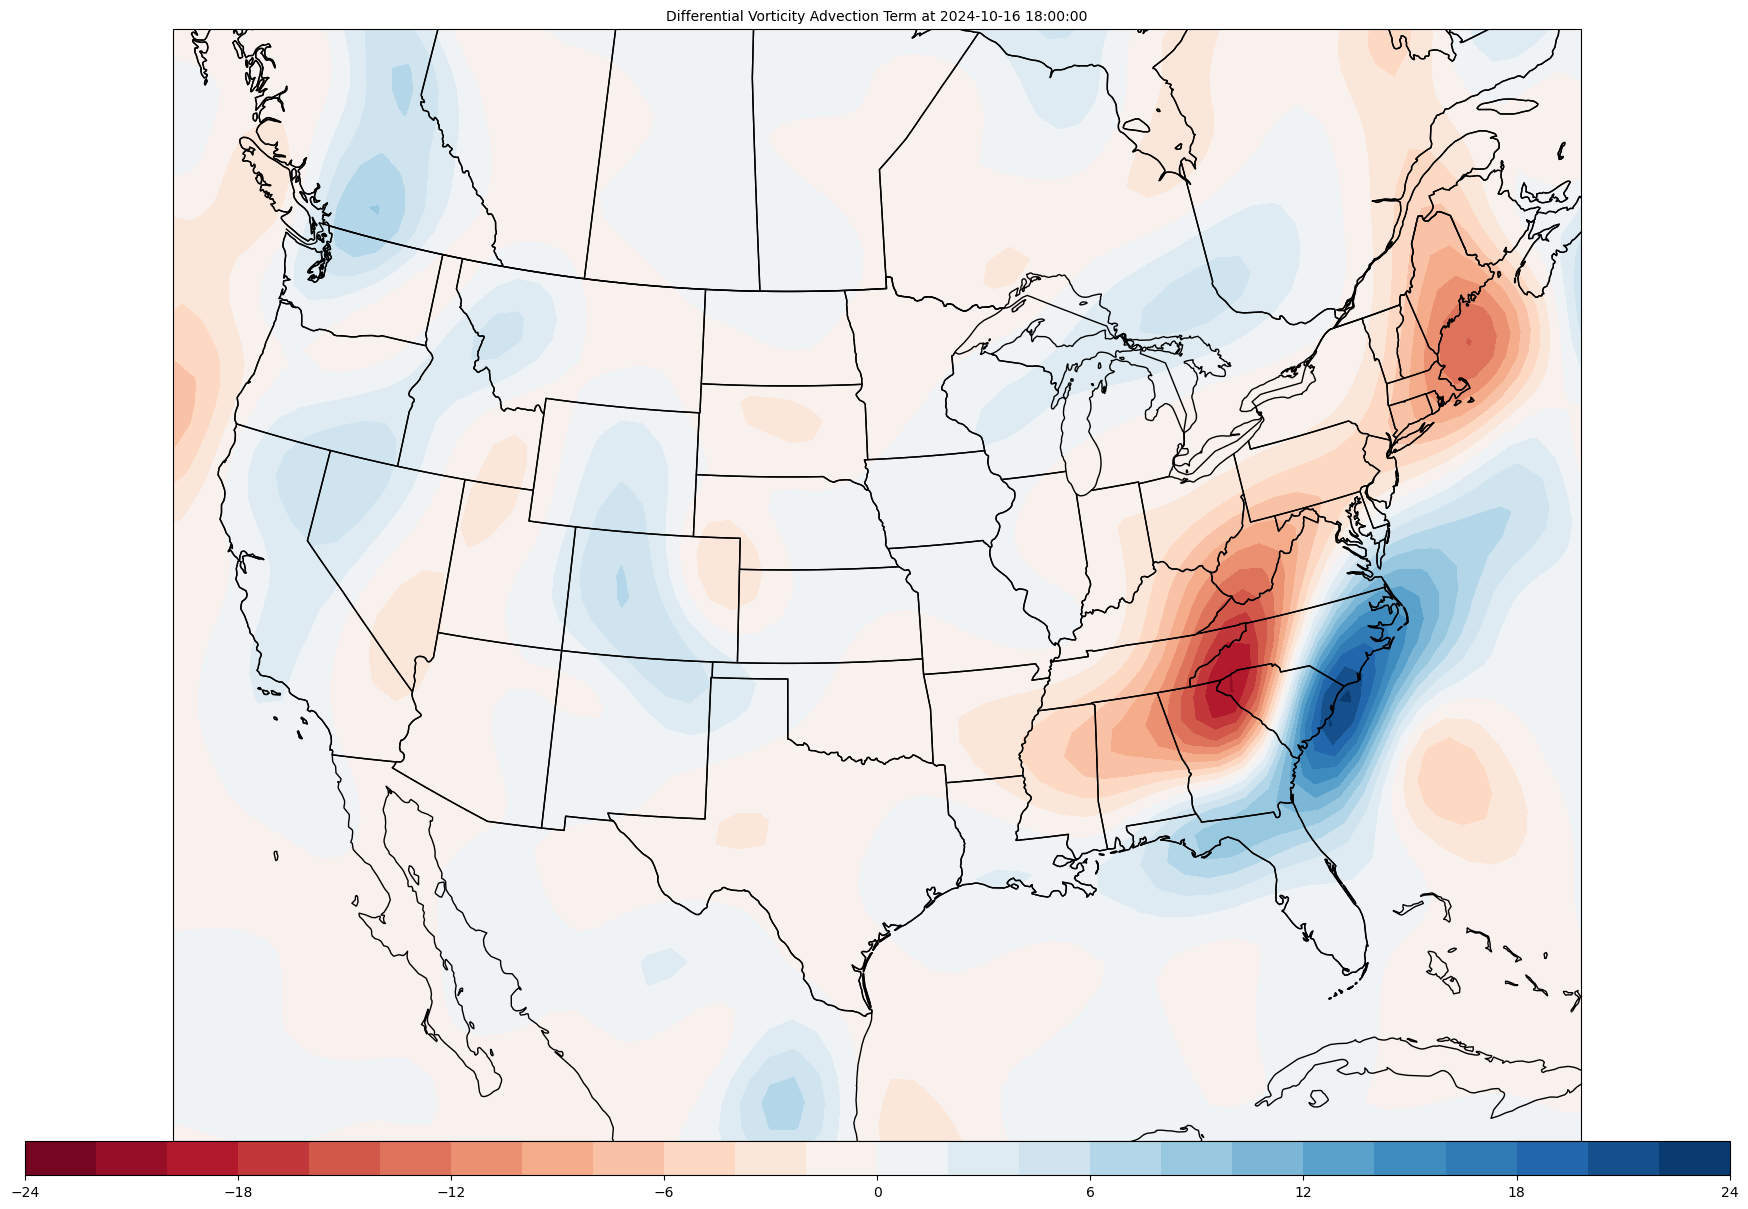

In [5]:
diffvortadv = FilledContourPlot()
diffvortadv.data = finalterm
diffvortadv.time = plot_time
diffvortadv.contours = range(-24,25,2)
diffvortadv.scale = 1e16
diffvortadv.colorbar = 'horizontal'
diffvortadv.colormap = 'RdBu'
diffvortadv.plot_units = '1/s**2'

panel = MapPanel()
panel.area = [-120, -74, 22, 55]
panel.projection = 'lcc'
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'Differential Vorticity Advection Term at {plot_time}'
panel.plots = [diffvortadv]

pc = PanelContainer()
pc.size = (22,17)
pc.panels = [panel]
pc.show()